In [1]:
import sys
sys.path.append(r'/Users/kostastsampourakis/Desktop/code/Python/projects/gaussfiltax')

from jax import numpy as jnp
from jax import random as jr

from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
import time
import gaussfiltax.inference as gf
import gaussfiltax.particlefilt as pf

from gaussfiltax.models import ParamsNLSSM, NonlinearSSM, ParamsBPF
from gaussfiltax import utils

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## Models and simulations

In [2]:
# Tracking
state_dim = 4
state_noise_dim = 2
emission_dim = 1
emission_noise_dim = 1
seq_length = 30
mu0 = 1.0 * jnp.array([-0.05, 0.001, 0.7, -0.05])
# mu0 = jnp.ones(state_dim)
q0 = jnp.zeros(state_noise_dim)
r0 = jnp.zeros(emission_noise_dim)
Sigma0 = 1.0 * jnp.array([[0.1, 0.0, 0.0, 0.0],[0.0, 0.005, 0.0, 0.0],[0.0, 0.0, 0.1, 0.0],[0.0, 0.0, 0.0, 0.01]])
Q = 1e-6 * jnp.eye(state_noise_dim)
R = 25*1e-6 * jnp.eye(emission_noise_dim)

dt = 0.5
F = jnp.array([[1, dt, 0, 0],[0, 1, 0, 0],[0, 0, 1, dt],[0, 0, 0, 1]])
acc = 0.5
Omega = lambda x, acc: 0.1 * acc / jnp.sqrt(x[1]**2 + x[3]**2)
Fman =  lambda x, a: jnp.array([[1, jnp.sin(dt * Omega(x, a)) / Omega(x, a), 0, -(1-jnp.cos(dt * Omega(x, a))) / Omega(x, a)],
                            [0, jnp.cos(dt * Omega(x, a)), 0, -jnp.sin(dt * Omega(x, a))],
                            [0, (1-jnp.cos(dt * Omega(x, a))) / Omega(x, a), 1, jnp.sin(dt * Omega(x, a)) / Omega(x, a)],
                            [0, jnp.sin(dt * Omega(x, a)), 0, jnp.cos(dt * Omega(x, a))]])
G = jnp.array([[0.5, 0],[1, 0],[0, 0.5],[0, 1]])
fBOT = lambda x, q, u: F @ x + G @ q
fManBOT = lambda x, q, u: (0.5*(u-1)*(u-2)*F - u*(u-2)*Fman(x, acc) + 0.5*u*(u-1) * Fman(x, -acc)) @ x + G @ q
gBOT = lambda x, r, u: jnp.arctan2(x[2], x[0]) + r
gBOTlp = lambda x, y, u: MVN(loc = gBOT(x, 0.0, u), covariance_matrix = R).log_prob(y)
# inputs = jnp.zeros((seq_length, 1))
inputs = jnp.array([1]*int(seq_length/3) + [0]*int(seq_length/3) + [2]*int(seq_length/3)) # maneuver inputs

In [3]:
f = fManBOT
g = gBOT
glp = gBOTlp

In [4]:
# initialization
model = NonlinearSSM(state_dim, state_noise_dim, emission_dim, emission_noise_dim)
params = ParamsNLSSM(
    initial_mean=mu0,
    initial_covariance=Sigma0,
    dynamics_function=f,
    dynamics_noise_bias= q0,
    dynamics_noise_covariance=Q,
    emission_function=g,
    emission_noise_bias= r0,
    emission_noise_covariance=R,
)

params_bpf = ParamsBPF(
    initial_mean=mu0,
    initial_covariance=Sigma0,
    dynamics_function=f,
    dynamics_noise_bias= q0,
    dynamics_noise_covariance=Q,
    emission_function=g,
    emission_noise_bias= r0,
    emission_noise_covariance=R,
    emission_distribution_log_prob = glp
)

# Generate synthetic data 
# key, _ = jr.split(jr.PRNGKey(0))
# key = jnp.array([2072131287, 2756572625], dtype=jnp.uint32)

key0 = jnp.array([2964592761, 3963767653], dtype=jnp.uint32)
states, emissions = model.sample(params, key0, seq_length, inputs = inputs)

In [5]:
# new_means = jr.multivariate_normal(key, jnp.zeros(4), jnp.zeros((4,4))-jnp.ones((4,4)))
# new_means = jnp.where(jnp.isnan(new_means), node_component.mean, new_means)


## Inference

Time taken for GSF:  1.0552728176116943
GSF RMSE: 0.109889194
Time taken for AGSF:  17.757076025009155
Time taken for BPF:  0.7383909225463867
AGSF RMSE: 23543849000000.0
BPF RMSE: 1.5400182


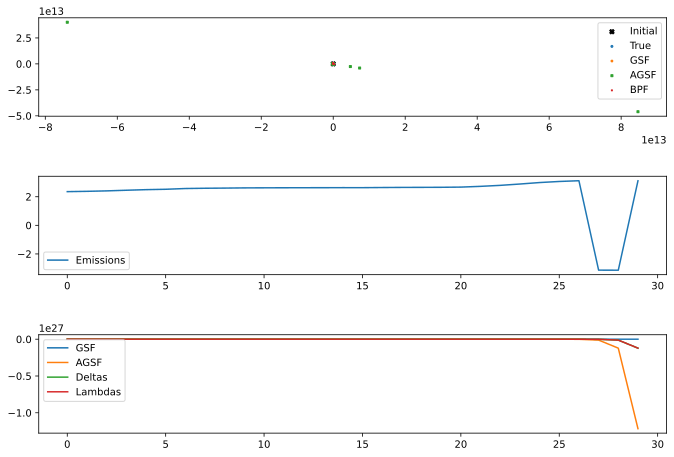

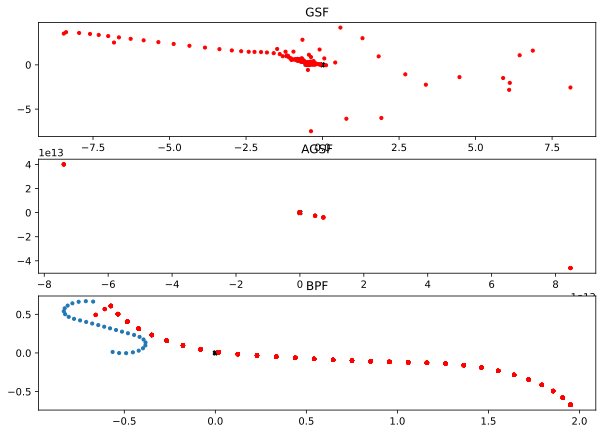

In [6]:
Nruns = 1
# GSF
M = 5
tin = time.time()
posterior_filtered_gsf = gf.gaussian_sum_filter(params, emissions, 5, 1, inputs)
point_estimate_gsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_gsf.means, posterior_filtered_gsf.weights), axis=0)
tout = time.time()
print('Time taken for GSF: ', tout - tin)
print('GSF RMSE:', utils.rmse(point_estimate_gsf, states)) 


num_particles = 100
for run in range(Nruns):
    key = jnp.array([1703955756, 4117464756], dtype=jnp.uint32)
    # key, next_key = jr.split(next_key)
    # AGSF
    tin = time.time()
    opt_args = (1.0, 1.0)
    num_components = [M, 5, 5] # has to be set correctly OW "TypeError: Cannot interpret '<function <lambda> at 0x12eae3ee0>' as a data type". Check internal containers._branch_from_node
    posterior_filtered_agsf, aux_outputs = gf.augmented_gaussian_sum_filter(params, emissions, num_components, rng_key = key, opt_args = opt_args, inputs=inputs)    
    point_estimate_agsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_agsf.means, posterior_filtered_agsf.weights), axis=0)
    tout = time.time()
    print('Time taken for AGSF: ', tout - tin)

    # BPF
    tin = time.time()
    ess = 0.5
    posterior_bpf = gf.bootstrap_particle_filter(params_bpf, emissions, num_particles, key, inputs, ess)
    point_estimate_bpf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_bpf["particles"], posterior_bpf["weights"]), axis=0)
    tout = time.time()

    print('Time taken for BPF: ', tout - tin)
                                                                         
    print('AGSF RMSE:', utils.rmse(point_estimate_agsf, states))
    print('BPF RMSE:', utils.rmse(point_estimate_bpf, states))

    fig, axes = plt.subplots(3, 1, sharex=False, figsize=(10, 7))
    fig.tight_layout(pad=3.0)
    axes[0].scatter(jnp.array([0]), jnp.array([0]), label = 'Initial', s = 20, marker = 'X', color = 'black')
    axes[0].scatter(states[:,0], states[:,2], label = 'True', s = 4)
    axes[0].scatter(point_estimate_gsf[:,0], point_estimate_gsf[:,2], label = 'GSF', s = 4, marker = 'x')
    axes[0].scatter(point_estimate_agsf[:,0], point_estimate_agsf[:,2], label = 'AGSF', s = 4, marker = 's')
    # axes[0].scatter(point_estimate_agsf_opt[:,0], point_estimate_agsf_opt[:,2], label = 'AGSF-O', s = 4, marker= 'd')
    axes[0].scatter(point_estimate_bpf[:,0], point_estimate_bpf[:,2], label = 'BPF', s = 4, marker = '+')
    axes[0].legend()   

    axes[1].plot(emissions, label = 'Emissions')
    axes[1].legend()

    axes[2].plot(jnp.sum(jnp.trace(posterior_filtered_gsf.covariances, axis1=2, axis2=3), axis=0)/M, label = 'GSF')
    axes[2].plot(jnp.sum(jnp.trace(posterior_filtered_agsf.covariances, axis1=2, axis2=3), axis=0)/M, label = 'AGSF')
    axes[2].plot(jnp.sum(jnp.trace(aux_outputs['Deltas'], axis1=2, axis2=3), axis=1)/5, label = 'Deltas')
    axes[2].plot(jnp.sum(jnp.trace(aux_outputs['Lambdas'], axis1=2, axis2=3), axis=1)/25, label = 'Lambdas')
    axes[2].legend()

    ### Plot 2 (all particles)
    fig2, axes2 = plt.subplots(3, 1, sharex=False, figsize=(10, 7))
    fig.tight_layout(pad=3.0)
    axes2[0].scatter(jnp.array([0]), jnp.array([0]), label = 'Initial', s = 20, marker = 'X', color = 'black')
    axes2[0].scatter(states[:,0], states[:,2], label = 'True', s = 10)
    for m in range(M):
        axes2[0].scatter(posterior_filtered_gsf.means[m, :, 0], posterior_filtered_gsf.means[m, : ,2], label = 'GSF', s = 10, color = 'red')
    axes2[0].title.set_text('GSF')

    axes2[1].scatter(jnp.array([0]), jnp.array([0]), label = 'Initial', s = 20, marker = 'X', color = 'black')
    axes2[1].scatter(states[:,0], states[:,2], label = 'True', s = 10)
    for m in range(M):
        axes2[1].scatter(posterior_filtered_agsf.means[m, :, 0], posterior_filtered_agsf.means[m, : ,2], label = 'AGSF', s = 10,  color = 'red')
    axes2[1].title.set_text('AGSF')

    axes2[2].scatter(jnp.array([0]), jnp.array([0]), label = 'Initial', s = 20, marker = 'X', color = 'black')
    axes2[2].scatter(states[:,0], states[:,2], label = 'True', s = 10)
    for m in range(num_particles):
        axes2[2].scatter(posterior_bpf["particles"][m, :, 0], posterior_bpf["particles"][m, : ,2], label = 'BPF', s = 10, color = 'red')
    axes2[2].title.set_text('BPF')

    plt.show()

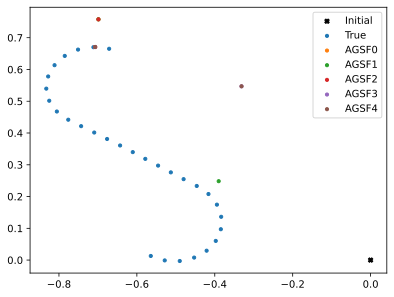

In [7]:
T=2
plt.scatter(jnp.array([0]), jnp.array([0]), label = 'Initial', s = 20, marker = 'X', color = 'black')
plt.scatter(states[:,0], states[:,2], label = 'True', s = 10)
for m in range(M):
    plt.scatter(posterior_filtered_agsf.means[m, :T, 0], posterior_filtered_agsf.means[m, :T ,2], label = 'AGSF{}'.format(m), s = 10)
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
plt.show()

In [8]:
t = 0
print('x', posterior_filtered_agsf.means[:, t, 0])
print('y', posterior_filtered_agsf.means[:, t, 2])
print('vx', posterior_filtered_agsf.means[:, t, 1])
print('vy', posterior_filtered_agsf.means[:, t, 3])

x [-0.698626   -0.698626   -0.698626   -0.33136496 -0.33136496]
y [0.7577869 0.7577869 0.7577869 0.5469837 0.5469837]
vx [-0.06195946 -0.06195946 -0.06195946  0.09691498  0.09691498]
vy [0.0303867  0.0303867  0.0303867  0.11556801 0.11556801]


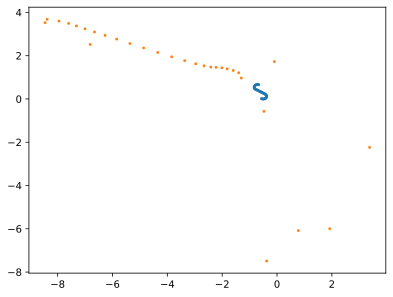

In [9]:
m=1
plt.scatter(states[:,0], states[:,2], label = 'True', s = 4)
plt.scatter(posterior_filtered_gsf.means[m,:, 0], posterior_filtered_gsf.means[m,:,2], label = 'GSF', s = 4, marker = 'x')
plt.show()

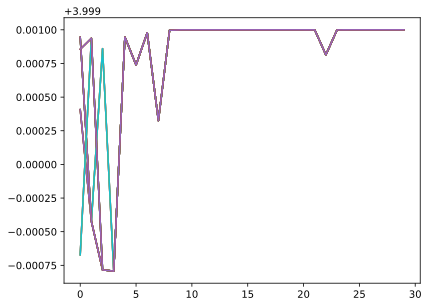

In [10]:
for m in range(25):
    plt.plot(jnp.trace(aux_outputs['grads_dyn'], axis1=2, axis2=3)[:,m], label = 'grad_dyn{m}'.format(m=m))
plt.show()

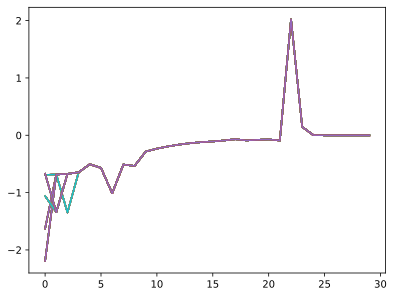

In [11]:
for m in range(125):
    plt.plot(jnp.trace(aux_outputs['grads_obs'], axis1=2, axis2=3)[:,m], label = 'grad_dyn{m}'.format(m=m))
# plt.legend()
plt.show()

In [12]:
jnp.trace(aux_outputs['gain'], axis1=2, axis2=3).shape

(30, 125)

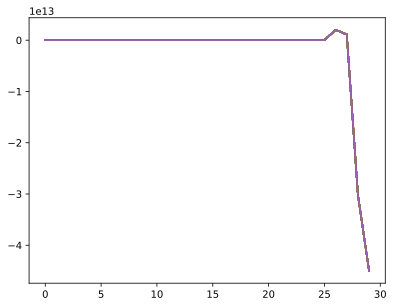

In [13]:
for m in range(125):
    plt.plot(jnp.trace(aux_outputs['gain'], axis1=2, axis2=3)[:,m] , label = 'grad_dyn{m}'.format(m=m))
# plt.legend()
plt.show()

In [14]:
posterior_bpf['weights'][:,5]

Array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01], dtype=float32)

In [15]:
print('GSF RMSE:', utils.rmse(point_estimate_gsf, states))                                                                           
print('AGSF RMSE:', utils.rmse(point_estimate_agsf, states))
print('BPF RMSE:', utils.rmse(point_estimate_bpf, states))

GSF RMSE: 0.109889194
AGSF RMSE: 23543849000000.0
BPF RMSE: 1.5400182


## Plots

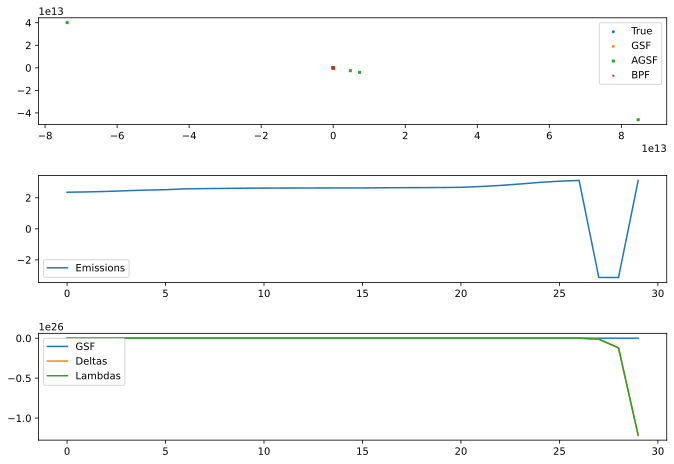

In [16]:
fig, axes = plt.subplots(3, 1, sharex=False, figsize=(10, 7))
fig.tight_layout(pad=3.0)
axes[0].scatter(states[:,0], states[:,2], label = 'True', s = 4)
axes[0].scatter(point_estimate_gsf[:,0], point_estimate_gsf[:,2], label = 'GSF', s = 4, marker = 'x')
axes[0].scatter(point_estimate_agsf[:,0], point_estimate_agsf[:,2], label = 'AGSF', s = 4, marker = 's')
# axes[0].scatter(point_estimate_agsf_opt[:,0], point_estimate_agsf_opt[:,2], label = 'AGSF-O', s = 4, marker= 'd')
axes[0].scatter(point_estimate_bpf[:,0], point_estimate_bpf[:,2], label = 'BPF', s = 4, marker = '+')
axes[0].legend()   

axes[1].plot(emissions, label = 'Emissions')
axes[1].legend()

axes[2].plot(jnp.sum(jnp.trace(posterior_filtered_gsf.covariances, axis1=2, axis2=3), axis=0)/M, label = 'GSF')
axes[2].plot(jnp.sum(jnp.trace(aux_outputs['Deltas'], axis1=2, axis2=3), axis=1)/5, label = 'Deltas')
axes[2].plot(jnp.sum(jnp.trace(aux_outputs['Lambdas'], axis1=2, axis2=3), axis=1)/25, label = 'Lambdas')
axes[2].legend()

plt.show()

In [17]:
jnp.allclose(posterior_bpf["particles"][0, :], posterior_bpf["particles"][1, :], atol=1e-1)
print(posterior_bpf["particles"][:, 16])
posterior_bpf["weights"][16]

[[ 0.8538248   0.2062535  -0.10860144 -0.01786521]
 [ 0.8538248   0.2062535  -0.10860144 -0.01786521]
 [ 0.8538248   0.2062535  -0.10860144 -0.01786521]
 [ 0.8538248   0.2062535  -0.10860144 -0.01786521]
 [ 0.8538248   0.2062535  -0.10860144 -0.01786521]
 [ 0.8538248   0.2062535  -0.10860144 -0.01786521]
 [ 0.8538248   0.2062535  -0.10860144 -0.01786521]
 [ 0.8538248   0.2062535  -0.10860144 -0.01786521]
 [ 0.8538248   0.2062535  -0.10860144 -0.01786521]
 [ 0.8538248   0.2062535  -0.10860144 -0.01786521]
 [ 0.8538248   0.2062535  -0.10860144 -0.01786521]
 [ 0.8538248   0.2062535  -0.10860144 -0.01786521]
 [ 0.8538248   0.2062535  -0.10860144 -0.01786521]
 [ 0.8538248   0.2062535  -0.10860144 -0.01786521]
 [ 0.8538248   0.2062535  -0.10860144 -0.01786521]
 [ 0.8538248   0.2062535  -0.10860144 -0.01786521]
 [ 0.8538248   0.2062535  -0.10860144 -0.01786521]
 [ 0.8538248   0.2062535  -0.10860144 -0.01786521]
 [ 0.8538248   0.2062535  -0.10860144 -0.01786521]
 [ 0.8538248   0.2062535  -0.10

Array([0.01      , 0.00859216, 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ],      dtype=float32)

### GSF

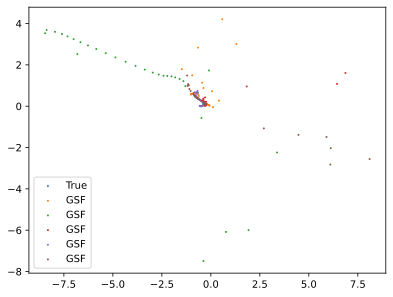

In [18]:
# num_components = M

# fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 7))
# fig.tight_layout(pad=3.0)
# axes[0].plot(states, label="xs")
# leg = ["states"]
# for m in range(M):
#     axes[0].plot(posterior_filtered_gsf.means[m])
#     leg.append("model {}".format(m))
#     axes[0].set_title("filtered means")
# #axes[0].legend(leg)

# if state_dim ==1:
#     for m in range(M):
#         axes[1].plot(posterior_filtered_gsf.covariances[m])
#         axes[1].set_title("filtered covariances")

# for m in range(M):
#     axes[2].plot(posterior_filtered_gsf.weights[m])
#     axes[2].set_title("weights")

# axes[3].plot(states, label="xs")
# leg = ["states", "GSF"]
# axes[3].plot(point_estimate_gsf)
# axes[3].legend(leg)
# axes[3].set_title("point estimate")
# plt.show()

plt.scatter(states[:, 0], states[:,2 ], label = 'True', s = 1)
for m in range(M):
    plt.scatter(posterior_filtered_gsf.means[m, :, 0], posterior_filtered_gsf.means[m, : ,2], label = 'GSF', s = 1)
    plt.legend()   
plt.show()

### AGSF

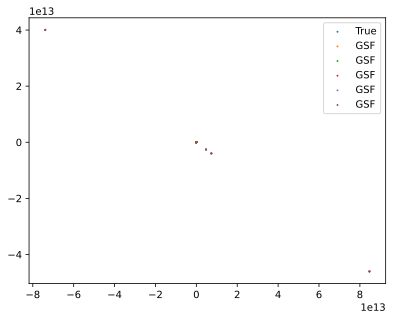

In [19]:
# fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 7))
# fig.tight_layout(pad=3.0)
# axes[0].plot(states, label="xs")
# leg = ["states"]
# for m in range(M):
#     axes[0].plot(posterior_filtered_agsf.means[m])
#     leg.append("model {}".format(m))
#     axes[0].set_title("filtered means")

# #axes[0].legend(leg)

# if state_dim == 1:
#     for m in range(M):
#         axes[1].plot(posterior_filtered_agsf.covariances[m].squeeze())
#         axes[1].set_title("filtered covariances")

# else:
#     for m in range(jnp.prod(num_components)):
#         axes[1].plot(aux_outputs["updated_means"][:,m])
#         axes[1].set_title("updated means")

# for m in range(jnp.prod(jnp.array(num_components))):
#         axes[2].plot(aux_outputs["pre_weights"][:,m])
#         axes[2].set_title("updated pre_weights")

# axes[3].plot(states, label="xs")
# leg = ["states", "AGSF"]
# axes[3].plot(point_estimate_agsf)
# axes[3].legend(leg)
# axes[3].set_title("point estimate")

# plt.show()

## Scatter plots (for target tracking example)
plt.scatter(states[:, 0], states[:,2 ], label = 'True', s = 1)
for m in range(M):
    plt.scatter(posterior_filtered_agsf.means[m, :, 0], posterior_filtered_agsf.means[m, : ,2], label = 'GSF', s = 1)
    plt.legend()   
plt.show()

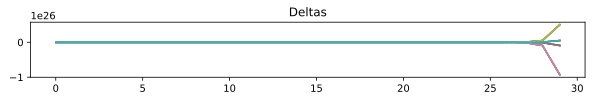

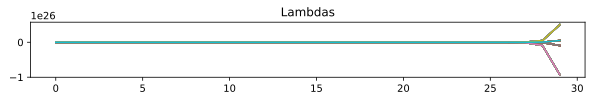

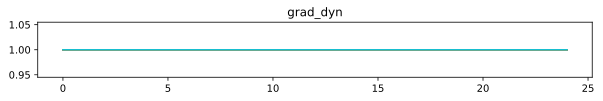

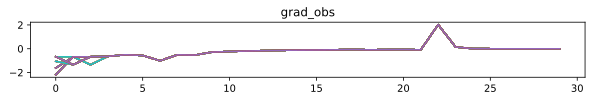

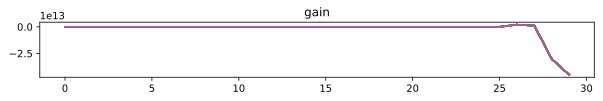

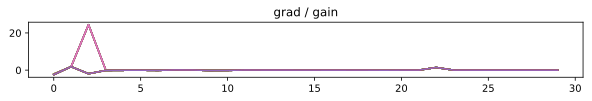

In [20]:
# plot Deltas
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["Deltas"].shape[1]):
    plt.plot(aux_outputs["Deltas"][:, i, 0])
plt.title('Deltas')
plt.show()

# plot Lambdas
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["Lambdas"].shape[1]):
    plt.plot(aux_outputs["Lambdas"][:, i, 0])
plt.title('Lambdas')
plt.show()

# plot grads_dyn
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["grads_dyn"].shape[0]):
    plt.plot(aux_outputs["grads_dyn"][i, :, 0, 0])
plt.title('grad_dyn')
plt.show()

# plot grads_obs
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["grads_obs"].shape[1]):
    plt.plot(aux_outputs["grads_obs"][:, i, 0, 0])
plt.title('grad_obs')
plt.show()

# plot gain
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["gain"].shape[1]):
    plt.plot(aux_outputs["gain"][:, i, 0, 0])
plt.title('gain')
plt.show()

# plot grads_dyn / gain
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["grads_dyn"].shape[1]):
    plt.plot(aux_outputs["grads_dyn"][:, i, 0, 0] / aux_outputs["gain"][:, i * 3, 0, 0])
plt.title('grad / gain')
plt.show()

### BPF

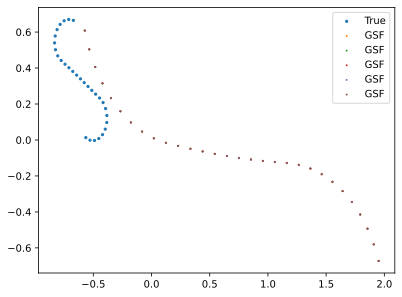

In [21]:
# fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 7))
# fig.tight_layout(pad=3.0)
# axes[0].plot(states, label="xs")
# leg = ["states"]
# for m in range(num_particles):
#     axes[0].plot(posterior_bpf["particles"][m])
#     leg.append("model {}".format(m))
#     axes[0].set_title("particles")

# for m in range(num_particles):
#     axes[1].plot(posterior_bpf["weights"][m])
#     axes[1].set_title("weights")

# plt.show()

## Scatter plots (for target tracking example)
plt.scatter(states[:, 0], states[:,2 ], label = 'True', s = 5)
for m in range(M):
    plt.scatter(posterior_bpf['particles'][m, :, 0], posterior_bpf['particles'][m, : ,2], label = 'GSF', s = 1)
    plt.legend()   
plt.show()